In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Data Overview



In [2]:
# Load the dataset
data = pd.read_pickle('Turbo_Charger_Data.pkl')

# Display the first few rows and check data types
print(data)
print(data.dtypes)


               N     R       C      D        F       G             H   I  \
0      12.771582  3.49  MR001A  0.306  HS5-M2D  178.72  34066.340308  11   
1      11.003039  3.49  MR001A  0.306  HS5-M2D  176.80  34014.048491  11   
2      11.316945  3.36  MR001A  0.306  HS5-M2D  335.52  30865.821890  12   
3      10.645816  3.36  MR001A  0.306  HS5-M2D  335.84  30849.654469  12   
4      12.229314  3.36  MR001A  0.306  HS5-M2D  335.20  30869.635489  12   
...          ...   ...     ...    ...      ...     ...           ...  ..   
20180   5.824881  1.53  MR05eH  0.385  HS9-M3S  372.32  37812.812606  16   
20181   5.444586  1.53  MR05eH  0.385  HS9-M3S  372.64  37804.346824  16   
20182   5.544038  1.53  MR05eH  0.385  HS9-M3S  372.96  37801.417426  16   
20183   5.189177  1.53  MR05eH  0.385  HS9-M3S  373.28  37807.124280  16   
20184   5.525636  1.53  MR05eH  0.385  HS9-M3S  373.60  37818.786887  16   

                  J  K  ...         DL         DM         DN         DP  \
0       6234

### Removing M and R column and Encoding

In [3]:
# Remove 'M' and 'R' columns as they are not needed for the model
data = data.drop(columns=['M', 'R'])

# Define the target column
target_column = 'N'

# Identify categorical columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
data[categorical_cols] = encoder.fit_transform(data[categorical_cols])

# Split into X (features) and y (target)
X = data.drop(columns=[target_column])
y = data[target_column]


### Correlation Matrix

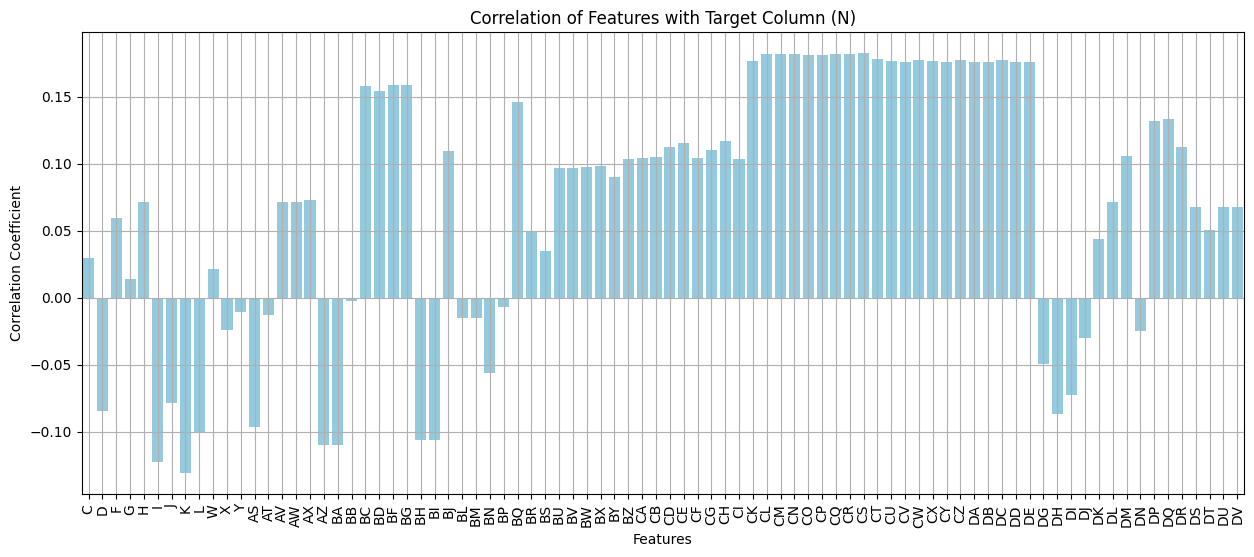

In [4]:
# Identify numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation between each feature and the target (N)
corr_with_target = X[numerical_cols].apply(lambda col: col.corr(y))

# Visualization: Bar plot of correlations with target
plt.figure(figsize=(15, 6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, color='skyblue')
plt.title('Correlation of Features with Target Column (N)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


### Feature Importance using Random Forest

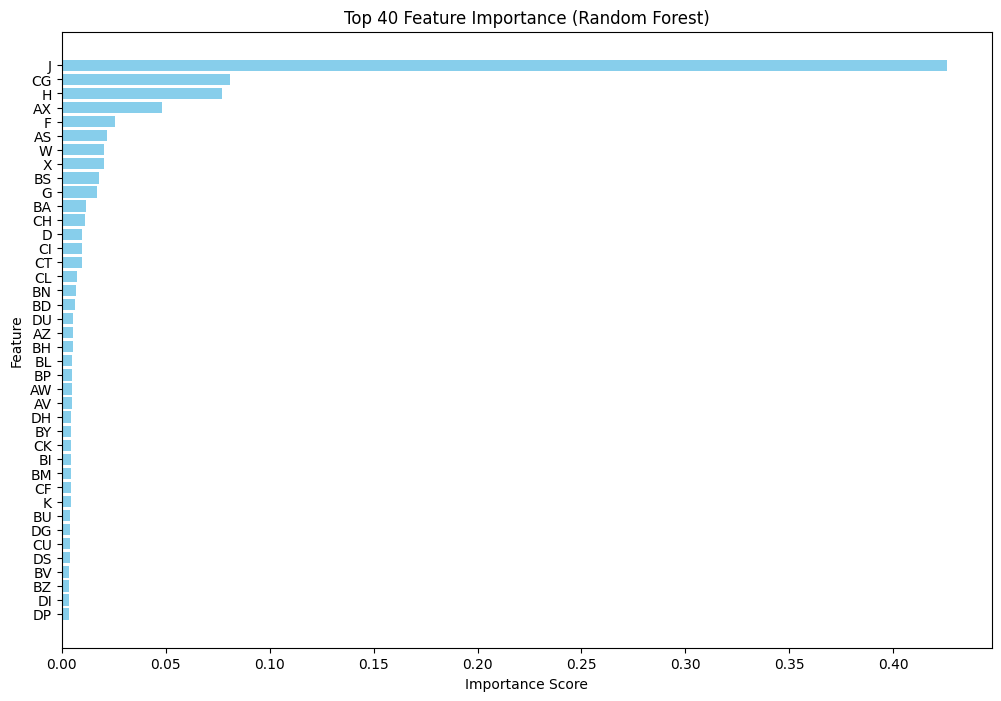

Top 40 Features selected by RandomForest Importance (in descending order of importance):
['J', 'CG', 'H', 'AX', 'F', 'AS', 'W', 'X', 'BS', 'G', 'BA', 'CH', 'D', 'CI', 'CT', 'CL', 'BN', 'BD', 'DU', 'AZ', 'BH', 'BL', 'BP', 'AW', 'AV', 'DH', 'BY', 'CK', 'BI', 'BM', 'CF', 'K', 'BU', 'DG', 'CU', 'DS', 'BV', 'BZ', 'DI', 'DP']


In [5]:
# Feature importance using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  
rf_model.fit(X, y)  # Fit model on full dataset

# Get feature importances
feature_importances = rf_model.feature_importances_

# Sort the feature importances in descending order (most important first)
sorted_idx = np.argsort(feature_importances)[::-1] 

# Get the top 40 features
top_40_idx = sorted_idx[:40]  

top_40_features = data.drop(columns=[target_column]).columns[top_40_idx]

# Plot the top 40 feature importances in reverse order
plt.figure(figsize=(12, 8))
plt.barh(X.columns[top_40_idx], feature_importances[top_40_idx], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 40 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  
plt.show()

# Print selected top 40 features in reverse order
top_40_features = X.columns[top_40_idx].tolist()
print("Top 40 Features selected by RandomForest Importance (in descending order of importance):")
print(top_40_features)



### Outlier Detection and Analysis

Isolation Forest Outlier Detection (including target column):
Total outliers detected: 1006

Data size before outlier detection: 20185
Data size remains unchanged as no modifications were made to original 'data'.


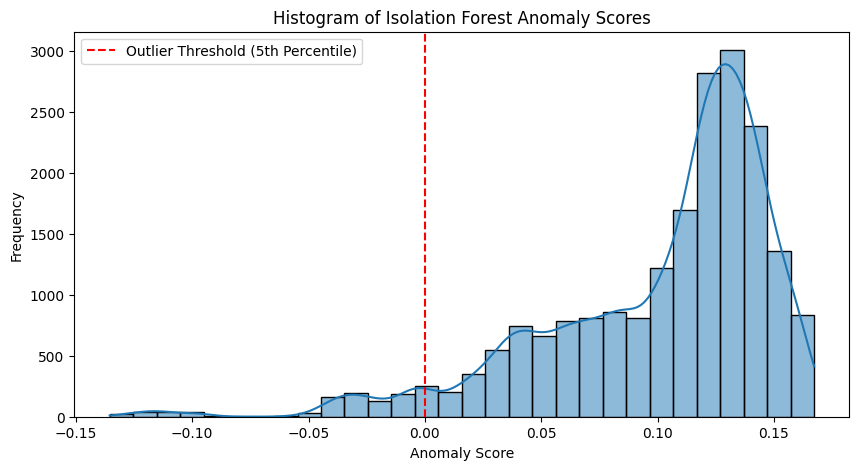

In [6]:
#Copy orginal data to Temproray data frame
temp_data = X.copy()
temp_data['N'] = y  

# Initial data size
initial_data_size = len(temp_data)

# Parameters for Isolation Forest
contamination = 0.05  

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(contamination=contamination, random_state=42)
iso_forest.fit(temp_data)  

# Get anomaly scores
outlier_scores = iso_forest.decision_function(temp_data)  

# Predict outliers (inliers are labeled as 1, outliers as -1)
outlier_predictions = iso_forest.predict(temp_data)  

# Convert predictions to boolean mask
all_outliers = outlier_predictions == -1  
outliers_count = all_outliers.sum()

# Print outlier detection summary
print("Isolation Forest Outlier Detection (including target column):")
print(f"Total outliers detected: {outliers_count}")
print("\nData size before outlier detection:", len(temp_data))
print("Data size remains unchanged as no modifications were made to original 'data'.")


# 🔹 Visualization : Histogram of Outlier Scores
plt.figure(figsize=(10, 5))
sns.histplot(outlier_scores, bins=30, kde=True)
plt.axvline(x=np.percentile(outlier_scores, 5), color='r', linestyle='--', label="Outlier Threshold (5th Percentile)")
plt.title("Histogram of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()



###  Feature Engineering and Analysis

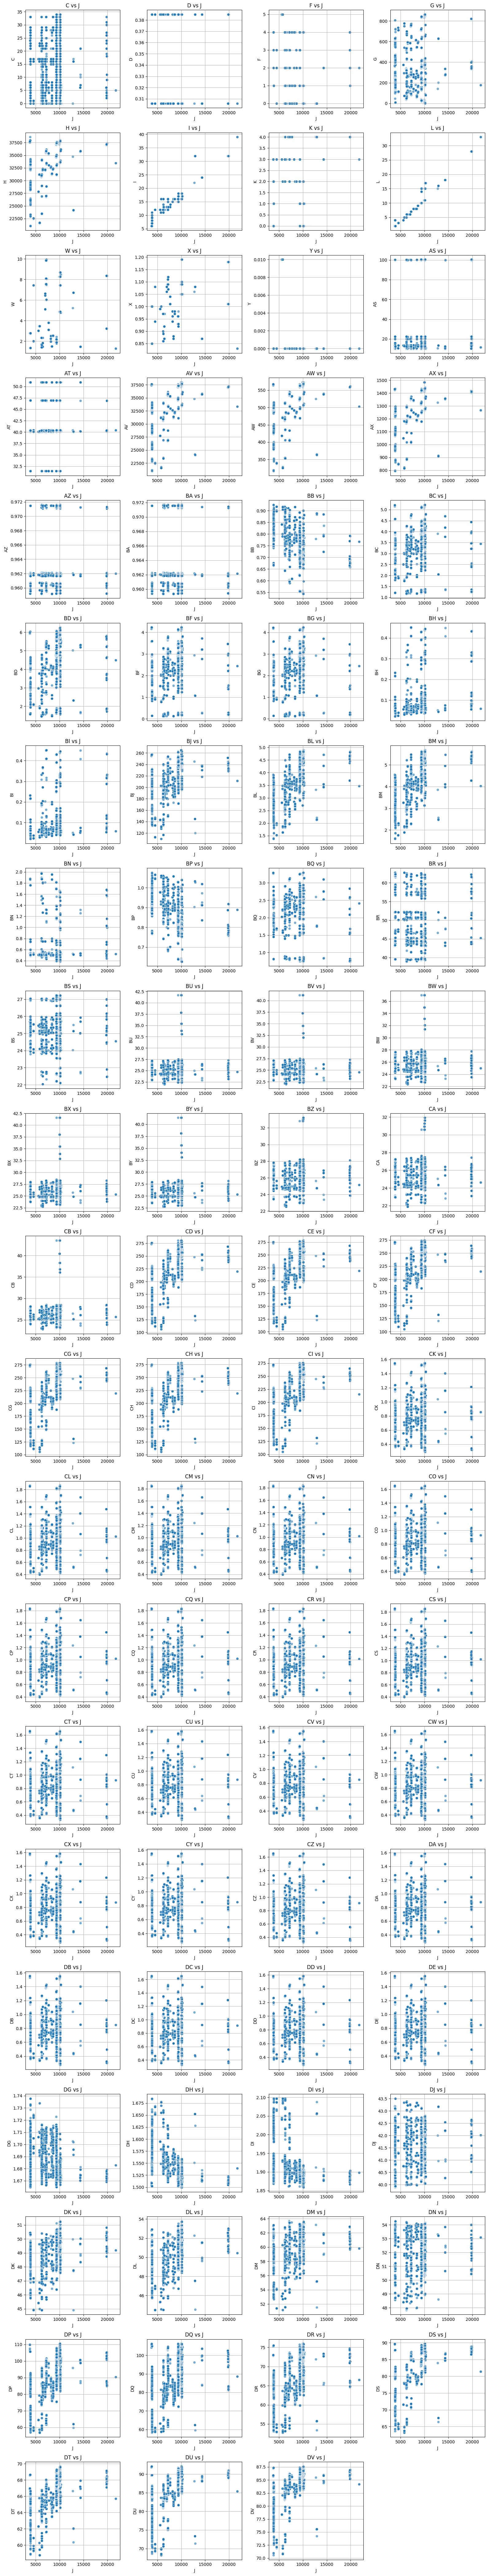

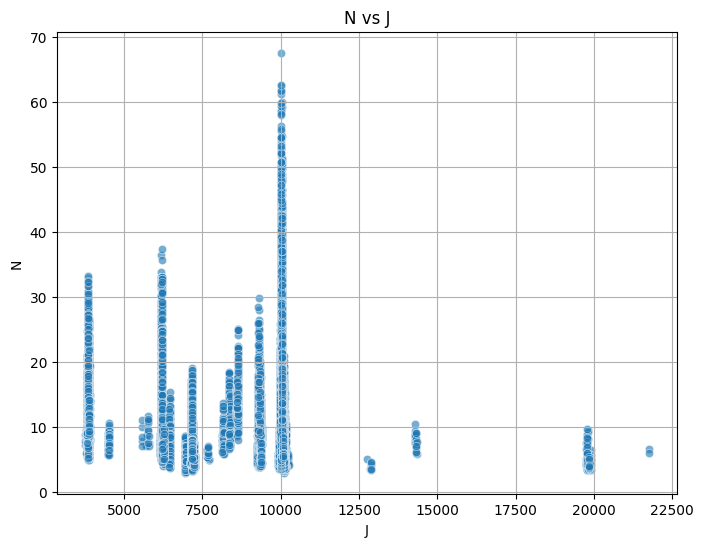

In [7]:
# Define features (excluding N and J)
features = [col for col in X.columns if col not in ['J']]

# Dynamically adjust rows and cols to plot all features vs J 
def plot_grid(features, x_column, y_data=None):
    num_features = len(features)
    cols = 4  # Number of columns in the grid
    rows = (num_features + cols - 1) // cols  # Calculate rows dynamically

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.scatterplot(x=X[x_column], y=X[feature], alpha=0.6, ax=axes[i])
        axes[i].set_title(f'{feature} vs {x_column}')
        axes[i].set_xlabel(x_column)
        axes[i].set_ylabel(feature)
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Plot N vs J if y_data (target column) is provided
    if y_data is not None:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X['J'], y=y_data, alpha=0.6)
        plt.title('N vs J')
        plt.xlabel('J')
        plt.ylabel('N')
        plt.grid(True)
        plt.show()

# Plot grid with features vs J
plot_grid(features, 'J', y_data=y)  # Pass target column (N) for plotting


### Scaling of all feature

In [8]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Splitting Data Based on J Frequency
low_freq_data = data[data['J'] < 10000]  # Low-frequency Data for RNN
high_freq_data = data[data['J'] >= 10000]  # High-frequency Data for RF

X_low = low_freq_data[top_40_features]
y_low = low_freq_data[target_column]
X_high = high_freq_data[top_40_features]
y_high = high_freq_data[target_column]

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_low_scaled = scaler_X.fit_transform(X_low)
y_low_scaled = scaler_y.fit_transform(y_low.values.reshape(-1, 1))

# Convert scaled X_low back to a DataFrame
X_low_scaled_df = pd.DataFrame(X_low_scaled, columns=X_low.columns)

# Convert scaled y_low back to a DataFrame
y_low_scaled_df = pd.DataFrame(y_low_scaled, columns=[target_column])

# Display the first few rows of the scaled data
print("Scaled X_low Head:")
print(X_low_scaled_df.head())

print("\nScaled y_low Head:")
print(y_low_scaled_df.head())



Scaled X_low Head:
          J        CG         H        AX    F        AS         W         X  \
0  0.397194  0.780695  0.741253  0.731194  0.0  0.005487  0.032520  0.148148   
1  0.398156  0.782083  0.738277  0.732359  0.0  0.005538  0.032520  0.148148   
2  0.386189  0.584599  0.559134  0.546780  0.0  0.005727  0.038328  0.185185   
3  0.386192  0.584599  0.558214  0.546780  0.0  0.005727  0.038328  0.185185   
4  0.386651  0.584599  0.559351  0.546780  0.0  0.005727  0.038328  0.185185   

         BS         G  ...        CF     K        BU        DG        CU  \
0  0.378522  0.202445  ...  0.798113  0.50  0.148331  0.635847  0.554487   
1  0.380940  0.200153  ...  0.799409  0.50  0.148268  0.637403  0.554872   
2  0.342001  0.389610  ...  0.603627  0.75  0.128418  0.585153  0.422615   
3  0.342001  0.389992  ...  0.603627  0.75  0.128418  0.585153  0.422615   
4  0.342001  0.389228  ...  0.603627  0.75  0.128418  0.585153  0.422615   

         DS        BV        BZ        DI  

### The Model RNN and Random Forest

[I 2025-02-04 14:53:16,479] A new study created in memory with name: no-name-f475ce4e-d557-46b2-b287-780122cf7968
[I 2025-02-04 14:53:29,111] Trial 0 finished with value: 0.07872329619915588 and parameters: {'units_1': 768, 'units_2': 192, 'dense_units': 8, 'learning_rate': 0.0001, 'batch_size': 128}. Best is trial 0 with value: 0.07872329619915588.
[I 2025-02-04 14:53:39,173] Trial 1 finished with value: 0.07676659200502478 and parameters: {'units_1': 384, 'units_2': 192, 'dense_units': 24, 'learning_rate': 0.0005, 'batch_size': 128}. Best is trial 1 with value: 0.07676659200502478.
[I 2025-02-04 14:53:49,167] Trial 2 finished with value: 0.08408446577580078 and parameters: {'units_1': 384, 'units_2': 128, 'dense_units': 24, 'learning_rate': 0.0001, 'batch_size': 128}. Best is trial 1 with value: 0.07676659200502478.
[I 2025-02-04 14:53:59,701] Trial 3 finished with value: 0.08000698251028855 and parameters: {'units_1': 1024, 'units_2': 448, 'dense_units': 24, 'learning_rate': 0.001, 


Best Hyperparameters for RNN: {'units_1': 640, 'units_2': 384, 'dense_units': 32, 'learning_rate': 0.0005, 'batch_size': 256}
Epoch 1: Train Loss = 0.1070, Validation Loss = 0.0893
Epoch 2: Train Loss = 0.0850, Validation Loss = 0.0832
Epoch 3: Train Loss = 0.0822, Validation Loss = 0.0809
Epoch 4: Train Loss = 0.0796, Validation Loss = 0.0799
Epoch 5: Train Loss = 0.0792, Validation Loss = 0.0799
Epoch 6: Train Loss = 0.0776, Validation Loss = 0.0787
Epoch 7: Train Loss = 0.0771, Validation Loss = 0.0763
Epoch 8: Train Loss = 0.0769, Validation Loss = 0.0763
Epoch 9: Train Loss = 0.0758, Validation Loss = 0.0765
Epoch 10: Train Loss = 0.0764, Validation Loss = 0.0773
Epoch 11: Train Loss = 0.0758, Validation Loss = 0.0749
Epoch 12: Train Loss = 0.0753, Validation Loss = 0.0764
Epoch 13: Train Loss = 0.0751, Validation Loss = 0.0752
Epoch 14: Train Loss = 0.0753, Validation Loss = 0.0755
Epoch 15: Train Loss = 0.0749, Validation Loss = 0.0752
Epoch 16: Train Loss = 0.0738, Validation 

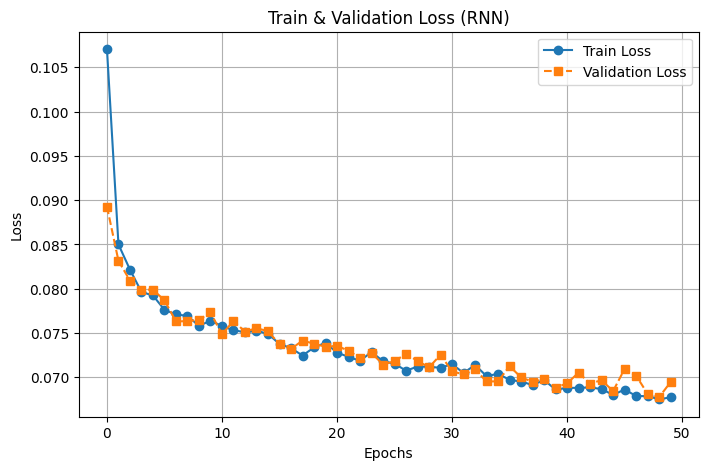


Random Forest Validation MAE: 0.2055


In [9]:
warnings.filterwarnings("ignore")

# Reshape for RNN (samples, timesteps, features)
X_low_rnn = torch.tensor(X_low_scaled).float().view(X_low_scaled.shape[0], 1, X_low_scaled.shape[1])
y_low_scaled = torch.tensor(y_low_scaled).float()

# Train-Test Split for RNN
X_train, X_val, y_train, y_val = train_test_split(X_low_rnn, y_low_scaled, test_size=0.2, random_state=42)

# Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, units_1, units_2, dense_units):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, units_1, batch_first=True)
        self.rnn2 = nn.RNN(units_1, units_2, batch_first=True)
        self.fc1 = nn.Linear(units_2, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Optuna Objective Function for RNN Hyperparameter Tuning
def objective(trial):
    units_1 = trial.suggest_int('units_1', 256, 1024, step=128)
    units_2 = trial.suggest_int('units_2', 128, 512, step=64)
    dense_units = trial.suggest_int('dense_units', 8, 32, step=8)
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.0005, 0.0001])
    batch_size = trial.suggest_categorical('batch_size', [128, 256])

    model = RNNModel(X_low_scaled.shape[1], units_1, units_2, dense_units)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validation Loss Calculation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()

    return val_loss / len(val_loader)

# Run Optuna Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print Best RNN Hyperparameters
best_params = study.best_params
print("\nBest Hyperparameters for RNN:", best_params)

# Train Best RNN Model
best_model = RNNModel(X_low_scaled.shape[1], best_params['units_1'], best_params['units_2'], best_params['dense_units'])
criterion = nn.L1Loss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=best_params['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(X_val, y_val)), batch_size=best_params['batch_size'], shuffle=False)

train_loss_history = []
val_loss_history = []

for epoch in range(50):
    best_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = best_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    # Compute Validation Loss
    best_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = best_model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
    
    val_loss /= len(val_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='s', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Validation Loss (RNN)')
plt.legend()
plt.grid(True)
plt.show()

# Train Random Forest Model for High-Frequency Data
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_high, y_high)

# Evaluate RF Model with Validation Split
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
y_val_pred_rf = rf_model.predict(X_val_rf)
rf_val_mae = mean_absolute_error(y_val_rf, y_val_pred_rf)

print(f"\nRandom Forest Validation MAE: {rf_val_mae:.4f}")

# Prediction Function
def predict(J_value, feature_values):
    feature_values = torch.tensor(feature_values).float().view(1, -1)

    if J_value < 10000:
        feature_values_scaled = torch.tensor(scaler_X.transform(feature_values)).float().view(1, 1, -1)
        best_model.eval()
        with torch.no_grad():
            prediction = best_model(feature_values_scaled)
        return scaler_y.inverse_transform(prediction.numpy())[0][0]
    else:
        return rf_model.predict(feature_values)[0]


### Visualisation of the Model

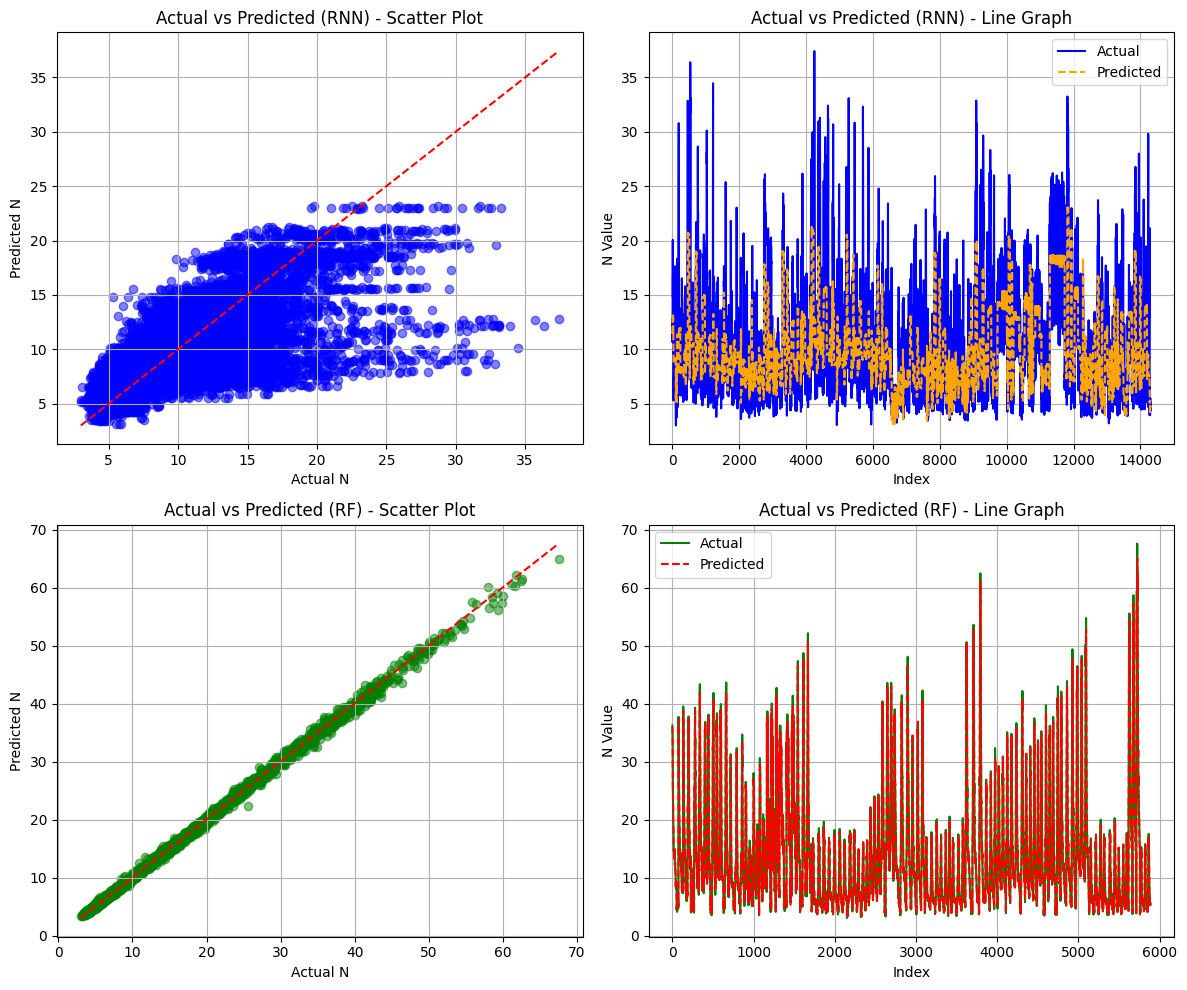

In [10]:
#  The model is in evaluation mode
best_model.eval()

# Generate Predictions for Low Frequency Data (RNN)
X_low_rnn_tensor = torch.tensor(X_low_rnn, dtype=torch.float32)

with torch.no_grad():  # Disable gradient calculations for inference
    y_low_pred_scaled = best_model(X_low_rnn_tensor).numpy()

y_low_pred = scaler_y.inverse_transform(y_low_pred_scaled)

# For High-Frequency Data (Random Forest)
y_high_pred = rf_model.predict(X_high)

# Plot Actual vs Predicted for RNN
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(y_low, y_low_pred, alpha=0.5, color='blue')
plt.plot([y_low.min(), y_low.max()], [y_low.min(), y_low.max()], 'r--')  # Ideal line
plt.xlabel("Actual N")
plt.ylabel("Predicted N")
plt.title("Actual vs Predicted (RNN) - Scatter Plot")
plt.grid(True)

# Plot Line Graph for RNN
plt.subplot(2, 2, 2)
plt.plot(y_low.values, label='Actual', color='blue')
plt.plot(y_low_pred, label='Predicted', color='orange', linestyle='dashed')
plt.xlabel("Index")
plt.ylabel("N Value")
plt.title("Actual vs Predicted (RNN) - Line Graph")
plt.legend()
plt.grid(True)

# Plot Actual vs Predicted for Random Forest
plt.subplot(2, 2, 3)
plt.scatter(y_high, y_high_pred, alpha=0.5, color='green')
plt.plot([y_high.min(), y_high.max()], [y_high.min(), y_high.max()], 'r--')  # Ideal line
plt.xlabel("Actual N")
plt.ylabel("Predicted N")
plt.title("Actual vs Predicted (RF) - Scatter Plot")
plt.grid(True)

# Plot Line Graph for Random Forest
plt.subplot(2, 2, 4)
plt.plot(y_high.values, label='Actual', color='green')
plt.plot(y_high_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel("Index")
plt.ylabel("N Value")
plt.title("Actual vs Predicted (RF) - Line Graph")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Using the Model to predict the N values

In [ ]:

warnings.filterwarnings("ignore")

# Load Test Dataset
test_df = pd.read_pickle("Turbo_Charger_Features.pkl")
test_df.dropna(inplace=True)
test_df.drop(columns=["M", "R"], inplace=True, errors="ignore")

# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns

# Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
test_df[categorical_cols] = encoder.fit_transform(test_df[categorical_cols])

test_features = test_df[top_40_features]
predictions = []

# Ensure RNN model is in evaluation mode
best_model.eval()

# Predict for Each Row in Test Data
for index, row in test_df.iterrows():
    J_value = row['J']
    feature_values = row[top_40_features].values.reshape(1, -1)

    if J_value < 10000:
        # Scale and convert to torch tensor
        feature_values_scaled = scaler_X.transform(feature_values).reshape(1, 1, -1)
        feature_tensor = torch.tensor(feature_values_scaled, dtype=torch.float32)

        # Make prediction with RNN
        with torch.no_grad():
            prediction = best_model(feature_tensor).numpy()
        predicted_N = scaler_y.inverse_transform(prediction)[0][0]
    else:
        # Prediction with Random Forest
        predicted_N = rf_model.predict(feature_values)[0]

    predictions.append(predicted_N)

test_df["Predicted_N"] = predictions
test_df.to_csv("Predicted_Test_N.csv", index=False)
print("Predictions saved to Predicted_Test_N.csv")


### Validating the Predicted Values

In [ ]:

# Load original data with true N values
original_data = pd.read_pickle("Turbo_Charger_Holdout.pkl")  
predicted_data = pd.read_csv("Predicted_Test_N.csv")  

# Print the number of rows in each file
print(f"Number of rows in Original_N_Values.csv: {len(original_data)}")
print(f"Number of rows in Predicted_N_Values.csv: {len(predicted_data)}")

# Ensure data alignment
if len(original_data) != len(predicted_data):
    raise ValueError("Mismatch in number of rows between original and predicted data.")

# Combine the two datasets for comparison
comparison_df = pd.DataFrame({
    'Original_N': original_data['N'],  
    'Predicted_N': predicted_data['Predicted_N']
})

# Calculate Metrics
mse_value = mean_squared_error(comparison_df['Original_N'], comparison_df['Predicted_N'])
mae_value = mean_absolute_error(comparison_df['Original_N'], comparison_df['Predicted_N'])

print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_value:.4f}")
print(f"Mean Absolute Error (MAE): {mae_value:.4f}")

# Display first few rows for verification
print("\nSample Actual vs. Predicted Data:")
print(comparison_df.head())

# Save comparison file
comparison_df.to_csv("Comparison_N_Values.csv", index=False)
print("Comparison data saved to 'Comparison_N_Values.csv'")

# Plot Actual vs. Predicted (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Original_N'], comparison_df['Predicted_N'], alpha=0.5, color='blue', label="Predictions")
plt.plot([comparison_df['Original_N'].min(), comparison_df['Original_N'].max()],
         [comparison_df['Original_N'].min(), comparison_df['Original_N'].max()], 
         color='red', linestyle='--', label="Ideal Fit (y = x)")

plt.xlabel("Actual N Values")
plt.ylabel("Predicted N Values")
plt.title("Actual vs. Predicted Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()

# Line Plot for Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Original_N'].values, label="Actual N", marker='o', linestyle='-')
plt.plot(comparison_df['Predicted_N'].values, label="Predicted N", marker='x', linestyle='--')

plt.xlabel("Index")
plt.ylabel("N Value")
plt.title("Actual vs. Predicted Line Graph")
plt.legend()
plt.grid(True)
plt.show()
